In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
import urllib.request, json
import os

from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas_datareader import data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

2025-01-15 00:07:53.393437: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 00:07:53.407459: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 00:07:53.454430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736899673.547656   22494 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736899673.570305   22494 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 00:07:53.638029: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### 1.1. Load the Data

In [2]:
df=pd.read_csv('../data/us_disaster_declarations.csv')

### 1.2. Clean States

In [3]:
# Clean states / remove territories 
mainland_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

df=df[df['state'].isin(mainland_states)]

### 1.3. Clean / Combine Incident Types

In [4]:
# List incident types to combine
common_disasters=['Severe Storm', 'Hurricane', 'Flood']

# Combine specified incidents into incident type 'winter weather'
for c in common_disasters:
    df.loc[df['incident_type'] == c, 'incident_type'] = 'Common Disasters'

In [5]:
# List incident types to drop
disaster_drops=['Biological', 'Snowstorm', 'Fire', 'Severe Ice Storm', 'Tornado', 'Drought', 'Coastal Storm', 
                'Other', 'Freezing', 'Earthquake', 'Typhoon', 'Tropical Storm', 'Volcanic Eruption', 'Winter Storm',
                'Fishing Losses', 'Mud/Landslide', 'Dam/Levee Break', 'Toxic Substances', 'Tsunami', 'Chemical', 'Human Cause', 'Terrorist']

# Drop specified incident types
for d in disaster_drops:
    df=df[df.incident_type != d]

### Unused for now

In [5]:
# List incident types to combine
winter_weather=['Severe Ice Storm', 'Snowstorm', 'Freezing', 'Winter Storm']

# Combine specified incidents into incident type 'winter weather'
for w in winter_weather:
    df.loc[df['incident_type'] == w, 'incident_type'] = 'Winter Weather'

#result = df[df['incident_type'] == 'Winter Weather']
#print(result)

### 1.4. Date Encoding

In [6]:
# Create 'incident_dtm' column to convert 'incident_begin_date' obj to datetime
df['incident_dtm']=pd.to_datetime(df['incident_begin_date'], format='%Y-%m-%dT%H:%M:%SZ')

### 1.5. Clean Columns

In [7]:
# Remove unneeded columns

# Create subset_df with 'incident_dtm', 'incident_type', and 'state'
subset_df=df[['incident_dtm', 'incident_type', 'state']]

subset_df.set_index('incident_dtm', inplace=True)

subset_df.head()

,incident_type,state
incident_dtm,,
1953-05-29,Common Disasters,LA
1953-06-06,Common Disasters,MT
1953-06-11,Common Disasters,IA
1953-06-19,Common Disasters,TX
1953-10-22,Common Disasters,FL


### 1.6. Monthly Aggregation and 'No Disaster' Feature

In [16]:
# Monthly aggregation and "no disaster" feature
monthly_disasters = subset_df.resample('M').size()
monthly_disasters_df = monthly_disasters.to_frame(name='disaster_count')
monthly_disasters_df['no_disaster'] = monthly_disasters_df['disaster_count'].apply(lambda x: 1 if x == 0 else 0)

monthly_disasters_df.head()

/tmp/ipykernel_6087/3477985905.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters = subset_df.resample('M').size()


,disaster_count,no_disaster
incident_dtm,,
1953-05-31,1,0
1953-06-30,3,0
1953-07-31,0,1
1953-08-31,0,1
1953-09-30,0,1


### 2.1. ARIMA Test

In [17]:
# Train-test split
split_date = '2019-01-01'
train = monthly_disasters_df[:split_date]['disaster_count']
test = monthly_disasters_df[split_date:]['disaster_count']

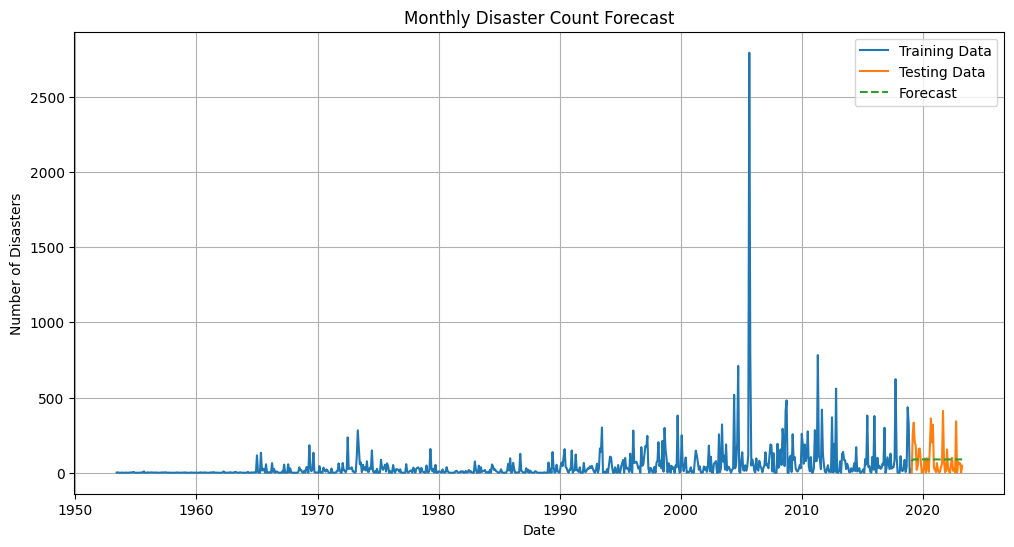

Root Mean Squared Error: 107.91252000062606


In [18]:
# ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Testing Data')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('Monthly Disaster Count Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Disasters')
plt.legend()
plt.grid()
plt.show()

# Evaluate model
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Root Mean Squared Error: {rmse}")

### 2.2. Logistic Regression Test

In [11]:
# Monthly aggregation and disaster binary
monthly_disasters = subset_df.resample('M').size()
monthly_disasters_df = monthly_disasters.to_frame(name='disaster_count')
monthly_disasters_df['disaster?'] = monthly_disasters_df['disaster_count'].apply(lambda x: 0 if x == 0 else 1)

monthly_disasters_df.head()

/tmp/ipykernel_22494/2553589897.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters = subset_df.resample('M').size()


,disaster_count,disaster?
incident_dtm,,
1953-05-31,1,1
1953-06-30,3,1
1953-07-31,0,0
1953-08-31,0,0
1953-09-30,0,0


In [12]:
train_data = monthly_disasters_df
test_data = monthly_disasters_df

train_data.head()

,disaster_count,disaster?
incident_dtm,,
1953-05-31,1,1
1953-06-30,3,1
1953-07-31,0,0
1953-08-31,0,0
1953-09-30,0,0


In [13]:
X_train = train_data.drop(["disaster?"], axis = 1)
y_train = train_data["disaster?"]
X_test = test_data.drop(["disaster?"], axis = 1)
y_test = test_data["disaster?"]

In [14]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [18]:
y_pred = model.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

1.0

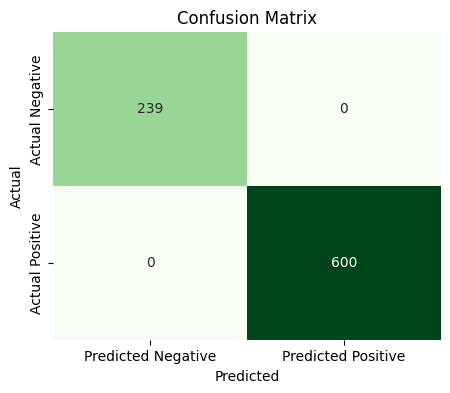

In [19]:
from sklearn.metrics import confusion_matrix

# Computing the confusion matrix
disaster_cm = confusion_matrix(y_test, y_pred)

# Converting the confusion matrix to a DataFrame for easier visualization
cm_df = pd.DataFrame(disaster_cm, 
                     index=['Actual Negative', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Positive'])

# Plotting the confusion matrix
plt.figure(figsize=(5, 4)) 
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False, cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()